# Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
vte = pd.read_csv('New_VTE.csv', index_col=False)
nvte = pd.read_csv('New_NVTE.csv', index_col=False)

In [3]:
vte = vte.iloc[:, 1:]
nvte = nvte.iloc[:, 1:]

In [4]:
# drop diagnossi & admit/type
vte = vte.drop(['DIAGNOSIS', 'ADMISSION_TYPE'], axis=1)
nvte = nvte.drop(['DIAGNOSIS', 'ADMISSION_TYPE'], axis=1)

In [5]:
#change gender into binary number
gender = {'M':1, 'F':0}
vte['GENDER'] = [gender[item] for item in vte['GENDER']]
nvte['GENDER'] = [gender[item] for item in nvte['GENDER']]

# change ethnicity into number
enthnicity = {'WHITE':1, 'BLACK':2, 'HISPANIC OR LATINO':3, 'ASIAN':4, 'MIDDLE EASTERN':4, 'PORTUGUESE':5, 
              'AMERICAN INDIAN/ALASKA NATIVE':6, 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER':7, 'OTHER':0,
              'UNKNOWN/NOT SPECIFIED':0, 'UNABLE TO OBTAIN':0, 'PATIENT DECLINED TO ANSWER':0, 'MULTI RACE ETHNICITY':0
             }
vte['ETHNICITY'] = [enthnicity[item] for item in vte['ETHNICITY']]
nvte['ETHNICITY'] = [enthnicity[item] for item in nvte['ETHNICITY']]

# change insurance into binary
insurance = {'Medicaid':1, 'Private':2, 'Medicare': 3, 'Government': 4, 'Self Pay': 5}
vte['INSURANCE'] = [insurance[item] for item in vte['INSURANCE']]
nvte['INSURANCE'] = [insurance[item] for item in nvte['INSURANCE']]

In [6]:
# add target columns for vte and nvte
vte['vte'] = 1
nvte['vte'] = 0

In [7]:
df = pd.concat([vte, nvte]).reset_index(drop=True)

In [8]:
df.head()

,SUBJECT_ID,HADM_ID,INSURANCE,ETHNICITY,GENDER,AGE,ADMIT_TIMES,LENGTH_STAY,READMIT_DAY,001-009,...,94,95,96,97,98,99,chemistry,hematology,blood gas,vte
0,32810,168208,1,1,1,0.000000,0.0,0.029940,0.103448,0,...,0,0,1,0,0,0,1,1,1,1
1,32810,189751,1,1,1,0.000000,0.0,0.215569,0.000000,0,...,0,0,1,0,0,0,1,1,1,1
2,109,124657,1,2,0,0.030769,1.0,0.023952,0.034483,0,...,0,0,0,0,0,0,1,1,0,1
3,109,176760,1,2,0,0.030769,1.0,0.000000,0.034483,0,...,0,0,0,0,0,0,1,1,1,1
4,91469,192145,2,1,1,0.046154,0.0,0.041916,0.344828,0,...,0,0,0,0,0,0,1,1,1,1


# Split Dataset

In [9]:
X = df.iloc[:, 2:(df.shape[1]-1)]
Y = df.iloc[:, df.shape[1]-1]

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state=42)

# Balanced Random Forest

In [11]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [39]:
# Create a dict for tuning parameters
brf_para = {}

In [40]:
brf_para['n_estimators'] = [65, 70, 75, 80, 85, 90, 95, 100]
brf_para['max_depth'] = [3, 5, 7]
brf_para['max_features'] = ['auto', 'sqrt', 'log2']

In [41]:
# GridSearch
brfc = BalancedRandomForestClassifier(random_state=0)
gsc = GridSearchCV(brfc, brf_para)

In [42]:
gsc.fit(X_train, Y_train)

GridSearchCV(estimator=BalancedRandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [65, 70, 75, 80, 85, 90, 95, 100]})

In [43]:
gsc.best_params_

{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100}

In [44]:
# Train the model with best parameters and predict
brf = BalancedRandomForestClassifier(n_estimators=100, max_depth=5, max_features = 'auto', random_state=0)
brf.fit(X_train, Y_train)
y_pred_brf = brf.predict(X_train)

In [45]:
# Output the sensitivity and specificity
tn, fp, fn, tp = metrics.confusion_matrix(Y_train, y_pred_brf).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(fp+tn)
print('Sensitivity: ', sensitivity)
print('Specificity: ', specificity)

Sensitivity:  1.0
Specificity:  0.8250973345312967


In [46]:
# Output the auc score
fpr, tpr, thresholds = metrics.roc_curve(Y_train, y_pred_brf)
auc_score = metrics.auc(fpr, tpr)
print('AUC: ', auc_score)

AUC:  0.9125486672656484


# Support vector machines

In [65]:
from sklearn.svm import SVC

In [66]:
# Create a dict for tuning parameters
svm_para = {}

In [67]:
svm_para['kernel'] = ['rbf', 'poly', 'sigmoid', 'linear']
svm_para['C'] = [0.1,1, 10, 100]
svm_para['gamma'] = [1,0.1,0.01,0.001]

In [68]:
# GridSearch
svm = SVC(random_state=0)
gsc_svm = GridSearchCV(svm, svm_para)

In [69]:
gsc_svm.fit(X_train, Y_train)

GridSearchCV(estimator=SVC(random_state=0),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']})

In [70]:
gsc_svm.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [31]:
# Train the model with best parameters and predict
svm_model = SVC(C=10, kernel = 'rbf', gamma = 0.1, random_state=0)
svm_model.fit(X_train, Y_train)
y_pred_svm = svm_model.predict(X_train)

In [54]:
# Output the sensitivity and specificity
tn2, fp2, fn2, tp2 = metrics.confusion_matrix(Y_train, y_pred_svm).ravel()
sensitivity_svm = tp2/(tp2+fn2)
specificity_svm = tn2/(fp2+tn2)
print('Sensitivity: ', sensitivity_svm)
print('Specificity: ', specificity_svm)

Sensitivity:  1.0
Specificity:  1.0


In [55]:
# Output the auc score
fpr2, tpr2, thresholds2 = metrics.roc_curve(Y_train, y_pred_svm)
auc_score2 = metrics.auc(fpr2, tpr2)
print('AUC: ', auc_score2)

AUC:  1.0


# Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression

In [22]:
# Create a dict for tuning parameters
lg_para = {'C':[1500, 1000, 100, 10, 1.0, 0.1, 0.01], 'penalty': ['l1', 'l2']}

In [23]:
# GridSearch
lgs = LogisticRegression(class_weight='balanced', max_iter = 1000000, solver = 'liblinear', random_state=0)
gsc_lg = GridSearchCV(lgs, lg_para)

In [24]:
gsc_lg.fit(X_train, Y_train)

GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000000, random_state=0,
                                          solver='liblinear'),
             param_grid={'C': [1500, 1000, 100, 10, 1.0, 0.1, 0.01],
                         'penalty': ['l1', 'l2']})

In [25]:
gsc_lg.best_params_

{'C': 1000, 'penalty': 'l1'}

In [27]:
# Train the model with best parameters and predict
lg = LogisticRegression(C = 1000, penalty = 'l1', class_weight='balanced', max_iter = 1000000, solver = 'liblinear', random_state=0)
lg.fit(X_train, Y_train)
y_pred_lg = lg.predict(X_train)

In [28]:
# Output the sensitivity and specificity
tn3, fp3, fn3, tp3 = metrics.confusion_matrix(Y_train, y_pred_lg).ravel()
sensitivity_lg = tp3/(tp3+fn3)
specificity_lg = tn3/(fp3+tn3)
print('Sensitivity: ', sensitivity_lg)
print('Specificity: ', specificity_lg)

Sensitivity:  1.0
Specificity:  0.955675351901767


In [29]:
# Output the auc score
fpr3, tpr3, thresholds3 = metrics.roc_curve(Y_train, y_pred_lg)
auc_score3 = metrics.auc(fpr3, tpr3)
print('AUC: ', auc_score3)

AUC:  0.9778376759508836


# ROC Curve

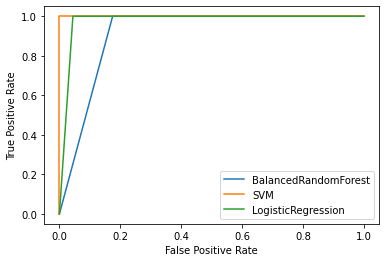

In [57]:
# ROC for BRM
plt.plot(fpr,tpr, label = 'BalancedRandomForest')
plt.plot(fpr2,tpr2, label = 'SVM')
plt.plot(fpr3,tpr3, label = 'LogisticRegression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()



# Test

In [35]:
y_test_pred = svm_model.predict(X_test)

In [36]:
metrics.accuracy_score(Y_test, y_test_pred)

0.9533678756476683

# Find Top 10 Significant Features In SVM Model

In [63]:
from sklearn.inspection import permutation_importance

In [73]:
perm_importance = permutation_importance(svm_model, X_test, Y_test)

feature_names = list(X_train.columns)
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()

In [86]:
index = sorted_idx[:10]

Text(0.5, 0, 'Permutation Importance')

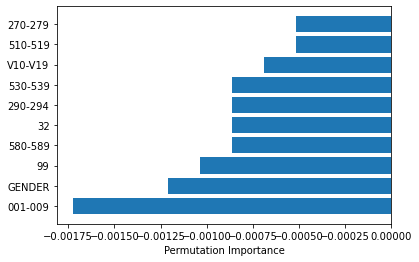

In [87]:
plt.barh(features[index], perm_importance.importances_mean[index])
plt.xlabel("Permutation Importance")

In [92]:
print('10 most revelent factors: \n', 'Intestinal Infectious Diseases\n', 'Gender\n',
                                    'Other Nonoperative Procedures\n', 
                                    'Nephritis, Nephrotic Syndrome, And Nephrosis\n', 
                                    'Excision Of Lung And Bronchus\n',
                                    'Organic Psychotic Conditions\n',
                                    'iseases Of Esophagus, Stomach, And Duodenum\n',
                                    'Persons With Potential Health Hazards Related To Personal And Family History\n',
                                    'Other Diseases Of Respiratory System\n',
                                    'Other Metabolic Disorders And Immunity Disorders\n')

10 most revelent factors: 
 Intestinal Infectious Diseases
 Gender
 Other Nonoperative Procedures
 Nephritis, Nephrotic Syndrome, And Nephrosis
 Excision Of Lung And Bronchus
 Organic Psychotic Conditions
 iseases Of Esophagus, Stomach, And Duodenum
 Persons With Potential Health Hazards Related To Personal And Family History
 Other Diseases Of Respiratory System
 Other Metabolic Disorders And Immunity Disorders



# Save the models

In [47]:
from joblib import dump, load

In [52]:
dump(lg, 'LogisticRegression.jlib')

['LogisticRegression.jlib']

In [49]:
model = load('BalancedRandomForest.jlib')